In [1]:
!pip install git+https://github.com/aleju/imgaug.git

  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-0ja03a5f
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-0ja03a5f
  Created wheel for imgaug: filename=imgaug-0.4.0-py3-none-any.whl size=971122 sha256=fb2866d1bd2cb0aec58e3f320949536972d0de59d2ac099a5ac1d8f6beb596f6
  Stored in directory: /tmp/pip-ephem-wheel-cache-zwwi3m7c/wheels/0c/78/b5/9303fae9d5e03df1f319adfe4e6534180b5c3232de11bc9a2f
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [2]:
%cd "/content/drive/MyDrive/Object Recognition/car_recognition"

/content/drive/MyDrive/Object Recognition/car_recognition


In [3]:
!python train.py --data_path "./datasets/full_animals.zip" \
        --destination_path "/content/sample_data/" \
        --input_shape "299, 299, 3" \
        --learning_rate 0.0001 \
        --batch_size 16 \
        --epochs 100 \
        --saved_weights "/content/sample_data/saved_weights/"

Exception ignored in: <function _get_module_lock.<locals>.cb at 0x7f43b2061c20>
Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 183, in cb
KeyboardInterrupt: 
Traceback (most recent call last):
  File "<frozen importlib._bootstrap_external>", line 87, in _path_is_mode_type
  File "<frozen importlib._bootstrap_external>", line 81, in _path_stat
FileNotFoundError: [Errno 2] No such file or directory: '/usr/local/lib/python3.7/dist-packages/keras/__init__.cpython-37m-x86_64-linux-gnu.so'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "train.py", line 7, in <module>
    import tensorflow as tf
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/__init__.py", line 55, in <module>
    from ._api.v2 import compat
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/compat/__init__.py", line 39, in <module>
    from . import v1
  File "/usr/local/lib/python3.7/dist-packages/tenso

In [4]:
!python train4.py --data_path "./datasets/full_animals.zip" \
        --destination_path "/content/sample_data/" \
        --input_shape "224, 224, 3" \
        --learning_rate 0.0001 \
        --batch_size 8 \
        --epochs 100 \
        --save_freq 50 \
        --info_freq 50 \
        --saved_weights "/content/sample_data/saved_weights/"

Successfully created the directory /content/sample_data/saved_weights/20220212_0208
2022-02-12 02:08:24.672265: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D) 

In [ ]:
%matplotlib inline

In [ ]:
import os
import json
import argparse
import datetime
import numpy as np

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

from train3 import create_folder_weights, get_args
from data_utils.data_flow import get_train_test_data
from models.finetune_model import finetune_mobilenet

def train(data_path, destination_path, input_shape, learning_rate, batch_size, epochs, save_freq, saved_weights):
    import cv2
    from matplotlib import pyplot as plt
    TRAINING_TIME_PATH = create_folder_weights(saved_weights)

    train_generator, test_generator = get_train_test_data(data_path,
                                                          destination_path, 
                                                          input_shape, 
                                                          batch_size, 
                                                          augmentor='mixing_ver2', 
                                                          normalizer=None)

    class_names = list(train_generator.classes.keys())

    with open(TRAINING_TIME_PATH + '/class_names.txt', 'w') as filehandle:
        for listitem in class_names:
            filehandle.write('%s\n' % listitem)
    num_class = len(class_names)

    model = finetune_mobilenet(transfer_layer=-1, fc_layer=fully_connected, num_classes=num_class)
    # model_shape = model.layers[0].output_shape[0][1:3]
    # transfer_layer = model.get_layer(index=-1)

    # loss = Focal_Loss(alpha=1)
    loss = tf.keras.losses.CategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = tf.keras.metrics.CategoricalCrossentropy(name='train_accuracy')

    test_loss = tf.keras.metrics.Mean(name='test_loss')
    test_accuracy = tf.keras.metrics.CategoricalCrossentropy(name='test_accuracy')

    print(train_generator.classes)
    @tf.function
    def train_step(images, labels):
        ### tets during train
        print("train")
        img = images.reshape(224, 224, 3)
        # img = np.clip(img, 0, 255)
        img = img.astype(np.uint8)
        plt.axis('off')
        plt.title(np.argmax(labels))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
        

        with tf.GradientTape() as tape:
            y_pred = model(images)
            loss_value = loss(labels, y_pred)
        gradients = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss(loss_value)
        train_accuracy(labels, y_pred)

        print(np.argmax(y_pred))
        

        
    
    @tf.function
    def test_step(images, labels):
        y_pred = model(images)
        t_loss = loss(labels, y_pred)

        test_loss(t_loss)
        test_accuracy(labels, y_pred)

    for epoch in range(epochs):
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()
        for step, (images, labels) in enumerate(train_generator):
            train_step(images, labels)
            if epoch % save_freq == 0:
                model.save_weights(filepath=TRAINING_TIME_PATH + "/epoch-{}".format(epoch), save_format="tf")

        for test_images, test_labels in test_generator:
            test_step(test_images, test_labels)

        print(
            f'Epoch: {epoch+1}/{epochs}, '
            f'step: {step+1}/{len(train_generator)}, '
            f'Train Loss: {train_loss.result():.4f}, '
            f'Train Accuracy: {train_accuracy.result():.4f}, '
            f'Test Loss: {test_loss.result():.4f}, '
            f'Test Accuracy: {test_accuracy.result():.4f}'
        )
        print('-'*50)

    model.save_weights(filepath=TRAINING_TIME_PATH + "saved_model", save_format="tf")

Successfully created the directory /content/sample_data/saved_weights/20220211_0103
Number of all layers in a feature-extractor part of model: 82.
Number of freezed (untrainable) layers in a feature-extractor part of model: 0.
{'dog': 0, 'house': 1, 'cat': 2, 'chickent': 3, 'elephant': 4}
train


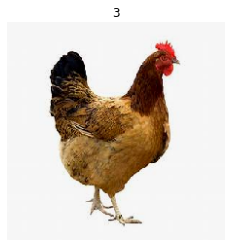

1
train


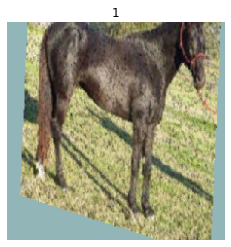

3
train


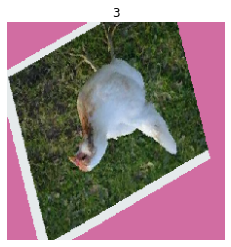

3
train


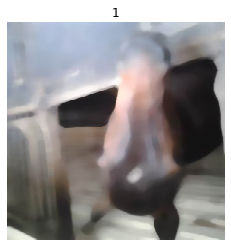

1
train


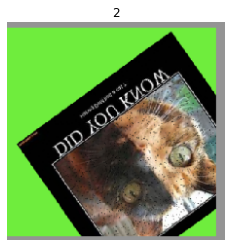

3
train


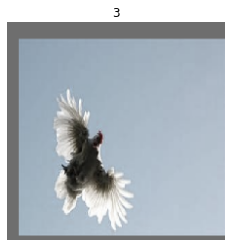

1
train


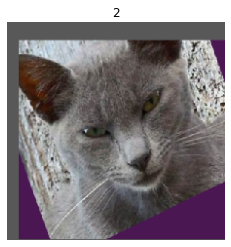

1
train


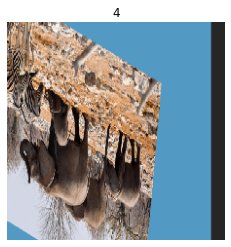

2
train


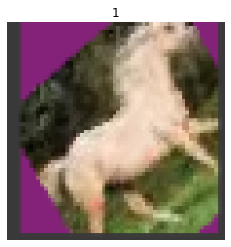

2
train


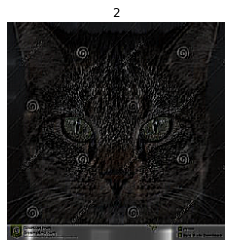

2
train


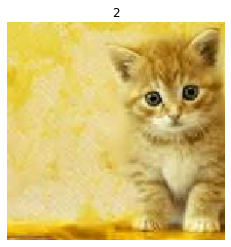

2
train


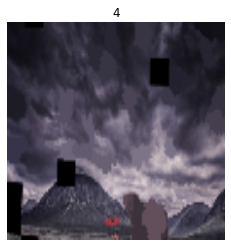

2
train


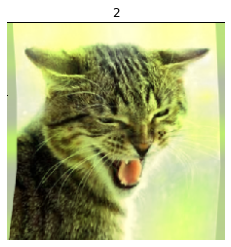

4
train


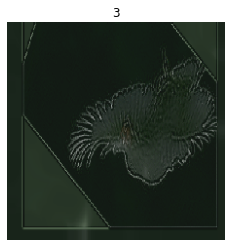

2
train


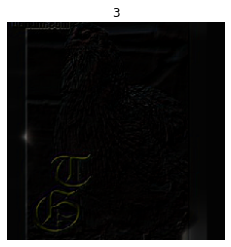

2
train


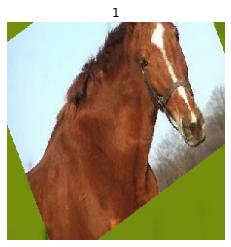

2
train


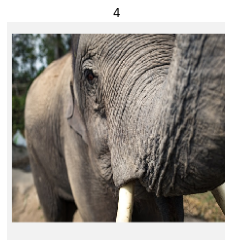

3
train


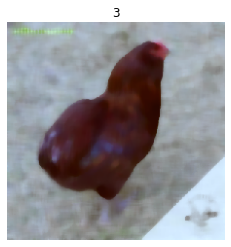

3
train


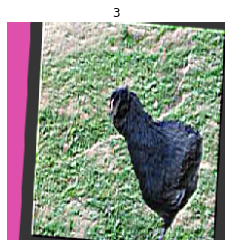

3
train


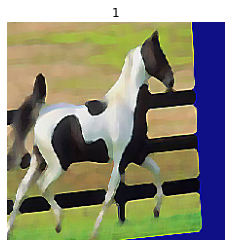

3
train


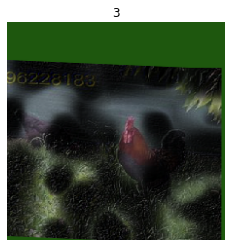

KeyboardInterrupt: ignored

In [ ]:
data_path = "./datasets/small_animals.zip"
destination_path = "/content/sample_data/" 
input_shape = (224, 224, 3) 
learning_rate = 0.0001
batch_size = 1
epochs = 100
save_freq = 5
saved_weights = "/content/sample_data/saved_weights/"
fully_connected = None

train(data_path, destination_path, input_shape, learning_rate, batch_size, epochs, save_freq, saved_weights)

In [ ]:
!unzip "./datasets/car_dataset.zip" -d "/content/sample_data/car_dataset"

In [ ]:
!python train2.py

Successfully created the directory /content/sample_data/saved_weights/20220210_0213
Found 406 images belonging to 10 classes.
Found 403 images belonging to 10 classes.
2022-02-10 02:13:14.535993: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Number of all layers in a feature-extractor part of model: 82.
Number of freezed (untrainable) layers in a feature-extractor part of model: 0.
Training used balanced class weights!
-------------------------------------------------------------------------------------
  ID  |   Class Name                                            |   Balance Percent            
------+---------------------------------------------------------+--------------------     
 0    | AM General Hummer SUV 2000                              |   90.22 %
 1    | Acura Integra Type R 2001                               |   90.22 %
 2    | 

In [ ]:
from models.core.mobilenet import MobileNet

model = MobileNet(include_top=True, weights ='imagenet', input_shape=(224,224,3))
model.summary()

In [ ]:
from models.finetune_model import finetune_vgg19
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout,GlobalAveragePooling2D,Input

args = [
		    GlobalAveragePooling2D(name='avg_pool'),
        Dropout(0.2),
        Dense(units=1024, name='dense1'),
        Dropout(0.4)
    ]
num_class = 100
model = finetune_vgg19(transfer_layer=-1, fc_layer=args, num_classes=num_class)
model.summary()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_test.flow_from_directory(
    directory="/content/sample_data/small_datasets/train/",
    target_size=(100, 100),
    color_mode="rgb",
    batch_size=2,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

Found 406 images belonging to 10 classes.


In [ ]:

for id, (item, label) in enumerate(train_generator):
  if id <= 10:
    # print(item.shape, label.shape)
    print(label)
    break

406
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
print(train_generator.classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


In [ ]:
print(train_generator.class_indices)

{'AM General Hummer SUV 2000': 0, 'Acura Integra Type R 2001': 1, 'Acura RL Sedan 2012': 2, 'Acura TL Sedan 2012': 3, 'Acura TL Type-S 2008': 4, 'Acura TSX Sedan 2012': 5, 'Acura ZDX Hatchback 2012': 6, 'Aston Martin V8 Vantage Convertible 2012': 7, 'Aston Martin V8 Vantage Coupe 2012': 8, 'Aston Martin Virage Convertible 2012': 9}


In [ ]:
from glob import glob
list_folder = glob("/content/sample_data/car_datasets/train/" + '*')

class_name = {a.split("/")[-1]:idx for idx, a in enumerate(list_folder)}
print(list_folder)
print(class_name)

['/content/sample_data/car_datasets/train/Acura Integra Type R 2001', '/content/sample_data/car_datasets/train/Acura ZDX Hatchback 2012', '/content/sample_data/car_datasets/train/AM General Hummer SUV 2000', '/content/sample_data/car_datasets/train/Aston Martin V8 Vantage Coupe 2012', '/content/sample_data/car_datasets/train/Aston Martin Virage Convertible 2012', '/content/sample_data/car_datasets/train/Acura TL Sedan 2012', '/content/sample_data/car_datasets/train/Acura TSX Sedan 2012', '/content/sample_data/car_datasets/train/Acura RL Sedan 2012', '/content/sample_data/car_datasets/train/Acura TL Type-S 2008', '/content/sample_data/car_datasets/train/Aston Martin V8 Vantage Convertible 2012']
{'Acura Integra Type R 2001': 0, 'Acura ZDX Hatchback 2012': 1, 'AM General Hummer SUV 2000': 2, 'Aston Martin V8 Vantage Coupe 2012': 3, 'Aston Martin Virage Convertible 2012': 4, 'Acura TL Sedan 2012': 5, 'Acura TSX Sedan 2012': 6, 'Acura RL Sedan 2012': 7, 'Acura TL Type-S 2008': 8, 'Aston Ma

In [ ]:
from glob import glob
list_folder = glob("/content/sample_data/car_datasets/test/" + '*')

for car in list_folder:
    print(car)

class_name = [a.split("/")[-1] for a in list_folder]
print(list_folder)
print(class_name)

/content/sample_data/car_datasets/test/Acura Integra Type R 2001
/content/sample_data/car_datasets/test/Acura ZDX Hatchback 2012
/content/sample_data/car_datasets/test/AM General Hummer SUV 2000
/content/sample_data/car_datasets/test/Aston Martin V8 Vantage Coupe 2012
/content/sample_data/car_datasets/test/Aston Martin Virage Convertible 2012
/content/sample_data/car_datasets/test/Acura TL Sedan 2012
/content/sample_data/car_datasets/test/Acura TSX Sedan 2012
/content/sample_data/car_datasets/test/Acura RL Sedan 2012
/content/sample_data/car_datasets/test/Acura TL Type-S 2008
/content/sample_data/car_datasets/test/Aston Martin V8 Vantage Convertible 2012
['/content/sample_data/car_datasets/test/Acura Integra Type R 2001', '/content/sample_data/car_datasets/test/Acura ZDX Hatchback 2012', '/content/sample_data/car_datasets/test/AM General Hummer SUV 2000', '/content/sample_data/car_datasets/test/Aston Martin V8 Vantage Coupe 2012', '/content/sample_data/car_datasets/test/Aston Martin Vi

Acura Integra Type R 2001


In [ ]:
a = (4, 224, 224, 3)
a[1:]

(224, 224, 3)